In [25]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
# import matplotlib.dates as mdates
from typing import List, Tuple, Optional

In [26]:
# Những hàm hỗ trợ cho quá trình trình làm đồ án Spline
def natural_Spline_coef(X: List[float], Y: List[float]) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
        Hàm này có nhiệm vụ là xử lý để lấy các hệ số cho các đa thức nội suy
        
        Tham số:
            X: những giá trị x trong bảng
            Y: tương ứng với giá trị X trong bảng cho ra 1 giá trị Y
        
        Trả về:
            List các hệ số a, b, c, d của Spline bậc 3
            Một tuple các list (a, b, c, d)
            (Có thể sẽ tách hàm để xử lý)
    """
    n = len(X)
    h = np.diff(X) # Tính ra những khoảng cách h trong dãy X

    alpha = np.zeros(n)
    for i in range(1, n - 1):
        alpha[i] = (3 / h[i]) * (Y[i + 1] - Y[i]) - (3 / h[i - 1]) * (Y[i] - Y[i - 1])
    
    A = np.zeros((n, n))
    A[0, 0] = 1
    A[-1, - 1] = 1

    for i in range(1, n - 1):
        A[i, i - 1] = h[i - 1]
        A[i, i] = 2 * (h[i - 1] + h[i])
        A[i, i + 1] = h[i]
    c = np.linalg.solve(A, alpha)

    a = Y[:-1]
    b, d = np.zeros(n - 1), np.zeros(n - 1)
    for i in range(n - 1):
        b[i] = (Y[i + 1] - Y[i]) / h[i] - (h[i] / 3) * (2 * c[i] + c[i + 1])
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])

    return a, b, c[:-1], d

def natural_Spline_Interpolation(x: float, X: List[float], a: List[float], b: List[float], c: List[float], d: List[float]) -> Optional[float]:
    """
        Nội suy bằng Spline bậc ba tự nhiên
        y = a + b(x - x_0) + c(x - x_0)^2 + d(x - x_0)^3

        Tham số:
            x: giá trị để thế vào 
            X: tập chứa các giá trị x
            a: một mảng chứa danh sách hệ số a
            b: một mảng chứa danh sách hệ số b
            c: một mảng chứa danh sách hệ số c
            d: một mảng chứa danh sách hệ số d
        
        Trả về:
            Giá trị sau khi áp dụng hàm nội suy
    """
    n = len(X)
    for i in range(n - 1):
        if X[i] <= x <= X[i + 1]:
            dx = x - X[i]
            return a[i] + b[i] * dx + c[i] * dx ** 2 + d[i] * dx ** 3
    return None

def polynominal_regression_model(X: List[float], Y: List[float], degree: int) -> List[float]:
    """
        Tính hệ số hồi quy đa thức

        Tham số:
            X: List giá trị x
            Y: List giá trị y ứng với x
            degree: bậc của đa thức hồi quy
        
        Trả về:
            List các hệ số    
    """
    n = len(X)
    A = np.zeros((n, degree + 1))
    for i in range(n):
        for j in range(degree + 1):
            A[i][j] = X[i] ** j

    A_T = A.T
    ATA = A_T @ A
    ATY = A_T @ np.array(Y).reshape(-1, 1)
    coef = np.linalg.solve(ATA, ATY)

    return coef.flatten().tolist()

def polynominal_regression_predict(x: float, coefs: List[float]) -> float:
    """
        Dự đoán giá trị y theo mô hình hồi quy đa thức
        Tham số:
            x: giá trị cần tính
            coefs: List hệ số 
        Trả về:
            Giá trị y dự đoán
    """
    return sum(coefs[i] * x**i for i in range(len(coefs)))

def showGraph():
    pass

# Nhiệt dung của dung dịch và nồng độ
Nhiệt dung của dung dịch axit sulfuric có liên quan đến nồng độ và tính chất được đo lường theo như mẫu số liệu thống kê của bài tập đồ án
Yêu cầu:
1. Hãy áp dụng Splines bậc 3 tự nhiên (natural cubic splines) và trình bày biểu đồ thực hiện đường cong Spline nội suy cùng với dữ liệu ban đầu
2. Đưa ra nhận xét về khả năng khớp đường cong spline nội suy trong việc thực hiện điều mà hồi quy đa thức không thể làm được

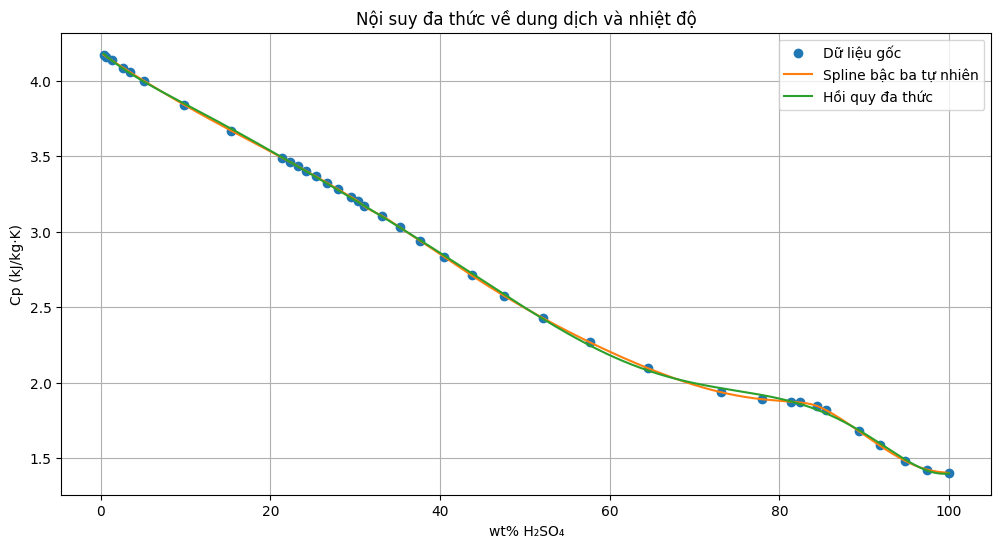

In [55]:
# Bài 1
weight_percent = np.array(
    [
        0.34, 0.68, 1.34, 2.65, 
        3.50, 5.16, 9.82, 15.36, 
        21.40, 22.27, 23.22, 24.25, 
        25.39, 26.63, 28.00, 29.52, 
        30.34, 31.00, 33.11, 35.25, 
        37.69, 40.49, 43.75, 47.57, 
        52.13, 57.65, 64.47, 73.13, 
        77.91, 81.33, 82.49, 84.48, 
        85.48, 89.36, 91.81, 94.82, 
        97.44, 100.00
    ], dtype=float
)

heat_capacity = np.array(
    [
        4.173, 4.160, 4.135, 4.087,
        4.056, 3.998, 3.842, 3.671,
        3.491, 3.465, 3.435, 3.403,
        3.367, 3.326, 3.281, 3.231,
        3.202, 3.173, 3.107, 3.030,
        2.940, 2.834, 2.711, 2.576,
        2.429, 2.269, 2.098, 1.938,
        1.892, 1.876, 1.870, 1.846,
        1.820, 1.681, 1.586, 1.484,
        1.425, 1.403
    ], dtype=float
)

a_spline_1, b_spline_1, c_spilne_1, d_spilne_1 = natural_Spline_coef(weight_percent, heat_capacity)
wp_new = np.linspace(min(weight_percent), max(weight_percent), 500)
hc_new = [natural_Spline_Interpolation(xi, weight_percent, a_spline_1, b_spline_1, c_spilne_1, d_spilne_1) for xi in wp_new]

degree = 8
coefs = polynominal_regression_model(weight_percent, heat_capacity, degree)

x_dense = np.linspace(min(weight_percent), max(weight_percent), 500)
y_dense = [polynominal_regression_predict(xi, coefs) for xi in x_dense]

plt.figure(figsize=(12, 6))
plt.plot(weight_percent, heat_capacity, 'o', label='Dữ liệu gốc')
plt.plot(wp_new, hc_new, label='Spline bậc ba tự nhiên')
plt.plot(x_dense, y_dense, label='Hồi quy đa thức')
plt.xlabel('wt% H₂SO₄')
plt.ylabel('Cp (kJ/kg·K)')
plt.title('Nội suy đa thức về dung dịch và nhiệt độ')
plt.grid(True)
plt.legend()
plt.show()

# Phân tích xu hướng dữ liệu Covid-19 bằng Spline bậc ba
1. Mục tiêu
    - Hiểu và áp dụng phương pháp spline bậc ba để làm trơn dữ liệu thời gian.
    - Phân tích xu hướng diễn biến của đại dịch Covid-19 dựa trên dữ liệu tần suất theo thời gian
2. Dữ liệu
    - Loại dữ liệu: Số ca nhiễm hàng ngày (không tích lũy) của Covid-19
    - Khu vực: Việt Nam
3. Các công việc
    - Tải dữ liệu (2020-2021 là dữ liệu ta cần lấy của Việt Nam)
    - Tiền xử lý dữ liệu (chuẩn hóa ngày tháng, loại bỏ dữ liệu thiếu hoặc ngoài lai)
    - Áp dụng Spline bậc ba tự nhiên nhằm tìm ra xu hướng chính đã diễn ra
    - Vẽ biểu đồ

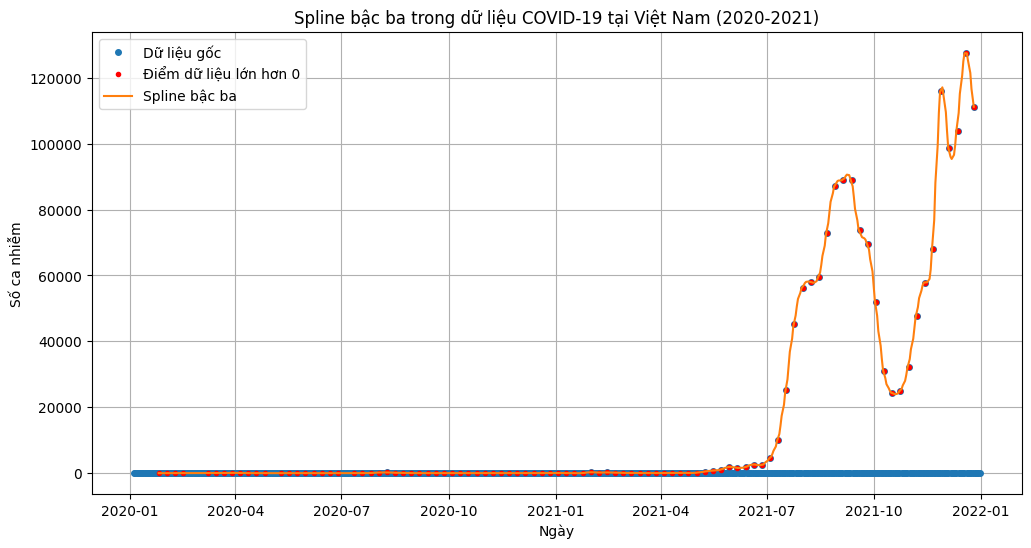

In [85]:
# Bài 2
# Tải dữ liệu và tiền xử lý dữ liệu
df = pd.read_csv("owid-covid-data.csv")

df_vn_full = df[df["location"] == "Vietnam"]
df_vn_full = df_vn_full[["date", "new_cases"]]
df_vn_full["date"] = pd.to_datetime(df_vn_full["date"])
df_vn_full = df_vn_full[(df_vn_full["date"] >= "2020-01-01") & (df_vn_full["date"] <= "2021-12-31")]

df_vn_full = df_vn_full.dropna(subset=['new_cases'])
df_vn_full["days"] = (df_vn_full["date"] - df_vn_full["date"].min()).dt.days

df_vn_nonzero = df_vn_full[df_vn_full["new_cases"] > 0]

days_nonzero = df_vn_nonzero["days"].tolist()
new_cases_nonzero = df_vn_nonzero["new_cases"].tolist()

a, b, c, d = natural_Spline_coef(days_nonzero, new_cases_nonzero)

x_smooth = np.linspace(min(days_nonzero), max(days_nonzero), 500)
y_smooth = [natural_Spline_Interpolation(xi, days_nonzero, a, b, c, d) for xi in x_smooth]

date_start = df_vn_full["date"].min()
date_smooth = pd.to_datetime([date_start + pd.Timedelta(days=int(x)) for x in x_smooth])

plt.figure(figsize=(12, 6))
plt.plot(df_vn_full["date"], df_vn_full["new_cases"], "o", markersize=4, label="Dữ liệu gốc")
plt.plot(df_vn_nonzero["date"], df_vn_nonzero["new_cases"], "ro", markersize=3, label="Điểm dữ liệu lớn hơn 0")
plt.plot(date_smooth, y_smooth, label='Spline bậc ba')
plt.xlabel("Ngày")
plt.ylabel("Số ca nhiễm")
plt.title("Spline bậc ba trong dữ liệu COVID-19 tại Việt Nam (2020-2021)")
plt.legend()
plt.grid(True)
plt.show()